In [ ]:
import pandas as pd
import os
import torch
import transformers
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

print(f"Using transformers version: {transformers.__version__}")
print(f"Using tensorflow version: {tf.__version__}")
print(f"Using torch version: {torch.__version__}")

Using transformers version: 4.50.3
Using tensorflow version: 2.19.0
Using torch version: 2.7.1+cu126


In [11]:
# Load Dataset
df = pd.read_csv("risk_analysis.csv")
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Mid-Risk
1,1,"trouble sleeping, confused mind, restless hear...",Mid-Risk
2,2,"All wrong, back off dear, forward doubt. Stay ...",Mid-Risk
3,3,I've shifted my focus to something else but I'...,Mid-Risk
4,4,"I'm restless and restless, it's been a month n...",Mid-Risk


In [13]:
df['status'].value_counts()

status
Mid-Risk     21832
Low-Risk     16343
High-Risk    14505
Name: count, dtype: int64

In [14]:
# Label Encoding
le = LabelEncoder()
df['status'] = le.fit_transform(df['status'])
df['status'].value_counts()

status
2    21832
1    16343
0    14505
Name: count, dtype: int64

In [33]:
# Split Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["statement"].to_numpy(), df["status"].to_numpy(), test_size=0.2, random_state=42
)
len(train_texts), len(test_texts), len(train_labels), len(test_labels)

(42144, 10536, 42144, 10536)

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_data(texts, max_len=128):
    return tokenizer(
        list(texts),
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )

train_encodings = tokenize_data(train_texts)
test_encodings = tokenize_data(test_texts)

In [ ]:
base_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

 
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# DistilBERT Layer
def distilbert_layer(inputs):
    return base_model(
        input_ids=inputs[0],
        attention_mask=inputs[1]
    )[0]   
  
distilbert_output = tf.keras.layers.Lambda(
    distilbert_layer,
    output_shape=(128, 768)
)([input_ids, attention_mask])

# BiLSTM Layer
bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(distilbert_output)

# Attention Block
def attention_block(inputs):
    query = tf.keras.layers.Dense(128, activation="relu")(inputs)
    key = tf.keras.layers.Dense(128, activation="relu")(inputs)
    value = tf.keras.layers.Dense(128, activation="relu")(inputs)
    attention_output = tf.keras.layers.Attention()([query, key, value])
    return attention_output

attention_output = attention_block(bi_lstm)

# CNN Layer
cnn_output = tf.keras.layers.Conv1D(128, kernel_size=3, activation="relu")(attention_output)
cnn_output = tf.keras.layers.GlobalMaxPooling1D()(cnn_output)

# Fully Connected Layers
dense = tf.keras.layers.Dense(64, activation="relu")(cnn_output)
dropout = tf.keras.layers.Dropout(0.3)(dense)
output = tf.keras.layers.Dense(3, activation="softmax")(dropout)   

# Build Model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

print(model.summary())

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128, 256)  │    918,528 │ lambda_1[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128, 128)  │     32,896 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128, 128)  │     32,896 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128, 128)  │     32,896 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 128, 128)  │          0 │ dense[0][0],      │
│ (Attention)         │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 126, 128)  │     49,280 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3)         │        195 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,074,947 (4.10 MB)

 Trainable params: 1,074,947 (4.10 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Train Model

train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    train_labels
)).shuffle(1000).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"]},
    test_labels
)).batch(32)

history = model.fit(train_dataset, validation_data=test_dataset, epochs=3)

In [ ]:
from sklearn.metrics import classification_report
y_preds=model.predict(test_dataset)
y_preds=tf.argmax(y_preds,axis=1)

print(classification_report(test_labels,y_preds,labels=[0,1,2],target_names={"High-Risk","Low-Risk","Mid-Risk"}))

330/330 [==============================] - 49s 143ms/step
              precision    recall  f1-score   support

   High-Risk       0.75      0.70      0.72      2869
    Mid-Risk       0.97      0.94      0.95      3325
    Low-Risk       0.78      0.84      0.81      4342

    accuracy                           0.83     10536
   macro avg       0.83      0.82      0.83     10536
weighted avg       0.83      0.83      0.83     10536



## Saving The Model

In [ ]:
save_dir = "risk_model_package"
os.makedirs(save_dir, exist_ok=True)
model.save(f"{save_dir}/model", save_format="tf")
tokenizer.save_pretrained(f"{save_dir}/tokenizer")
joblib.dump(le, f"{save_dir}/label_encoder.joblib")l
with open(f"{save_dir}/metadata.txt", "w") as f:
    f.write(f"Classes: {le.classes_.tolist()}\n")
    f.write(f"Max sequence length: 128\n")
    f.write(f"Last validation accuracy: {history.history['val_accuracy'][-1]:.4f}\n")


## Visualizing The Model Performance

### Confusion Matrix

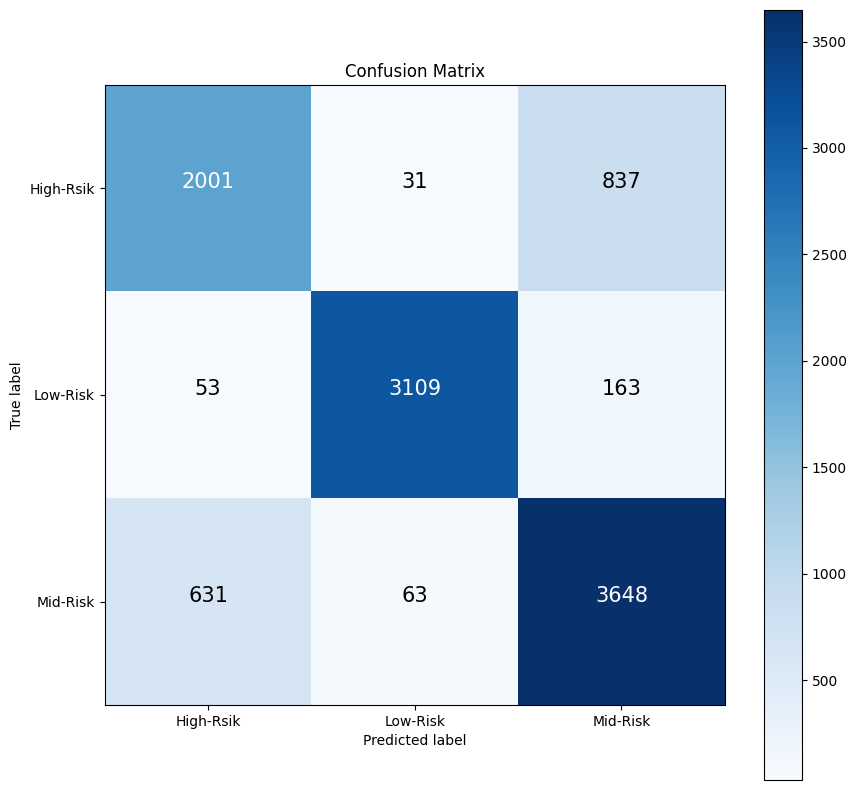

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

 
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
   
   
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
  n_classes = cm.shape[0]  

   
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)  
  fig.colorbar(cax)

  if classes is not None and len(classes) > 0:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
      
  if savefig:
    fig.savefig("confusion_matrix.png")

make_confusion_matrix(test_labels,y_preds,classes=le.classes_)

### Loss Curve and Accuracy Curve

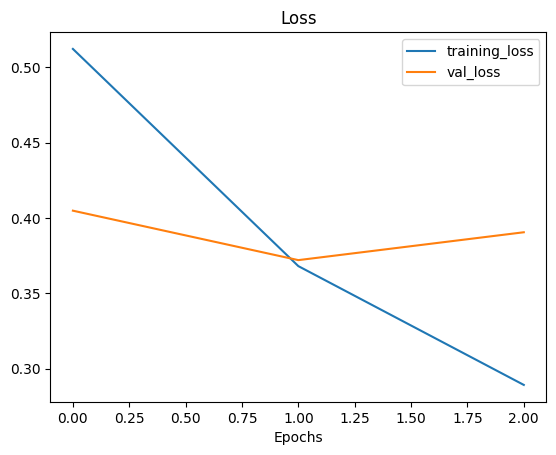

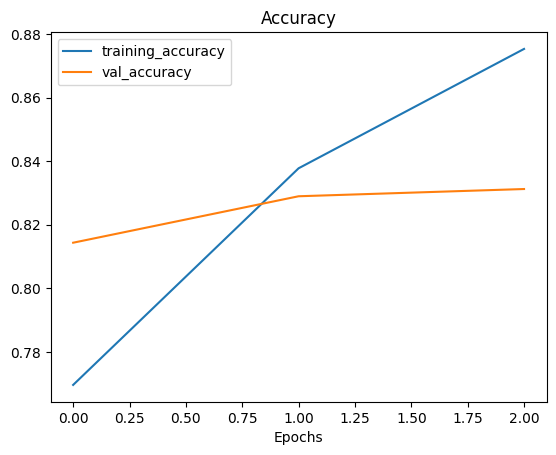

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
   
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

plot_loss_curves(history)